In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import itertools

In [2]:
pd.options.display.max_colwidth=800
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
df = pd.read_csv('datasets/SatisfactionClients/cdiscount.csv', index_col=0)
df_test = pd.read_csv('datasets/SatisfactionClients/amazon_test1.csv', index_col=0)
df.head(2)

,pays,note,titre,commentaire
0,FR,1,Les As du prélèvement illicite,"Il y a un jourLes As du prélèvement illicitePratiques à la limite de légal.J' ai pris un paiement en 4x dont il restait deux mois , pendant 1 semaine je ne retrouve pas ma carte , je la bloque temporairement.Le prelevement 3 ne passe pas Cdiscount m' informe qu' il faut régulariser, je retrouve ma carte et........boum deux prelevements simultanés des deux mensualités, celle du et l' autre prévue pour décembre.Cela me servira de leçon mais les vautours c 'est fini pour moi.Date de l'expérience: 14 novembre 2022"
1,FR,1,Commande une télévision avec rendez…,Il y a 13 heuresCommande une télévision avec rendez…Commande une télévision avec rendez vous du livreur. Je prend une journée de congé et le livreur ne vient pas. Je demande le renvoie de la télé chez Cdiscount. Cdiscount me rembourse la télé mes pas les 29 euros de livraison. Donc une journée de congé pour rien et un cadeau de 29 euros a Cdiscount. Plus jamais de commande sur Cdiscount.Date de l'expérience: 02 novembre 2022


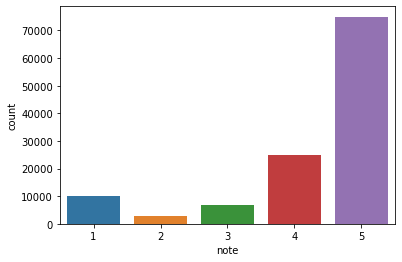

In [4]:
sns.countplot(x='note', data=df);

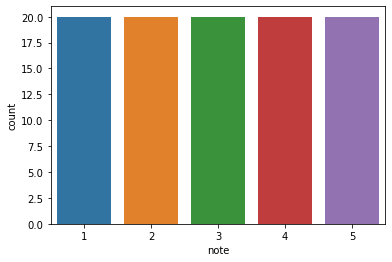

In [5]:
sns.countplot(x='note', data=df_test);

In [6]:
# séparation de la variable cible et des variables explicatives
X = df['commentaire']
y = df['note'].values

In [7]:
# séparation du jeu de données en un dataset d'entrainement et un dataset de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(df_test.shape)

(96000,)
(24000,)
(100, 4)


In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [10]:
# tokenisation des commentaires
num_words=4000
tk = Tokenizer(num_words=num_words, lower=True)

In [11]:
# entrainement de la tokenisation sur le X_train
tk.fit_on_texts(X_train)

In [12]:
# nb de ligne de la matrice
word_index = tk.word_index
len(tk.word_index)

82187

In [13]:
# nb de colonnes dans la matrice
vocabulary_size = tk.num_words
vocabulary_size

4000

In [14]:
# mise sous vecteur des commentaires
X_seq_train = tk.texts_to_sequences(X_train)
X_seq_test = tk.texts_to_sequences(X_test)

In [15]:
# affichage de la vectorisation réalisée
for x in range(0,5):
    print(X_seq_train[x])

[113, 41, 43, 286, 69, 3, 2947, 69, 3, 432, 1276, 1, 112, 32, 546, 165, 1, 28, 473, 82, 14, 129, 315, 193, 17, 350, 3, 40, 6, 1, 2, 142, 38, 7]
[84, 42, 9, 671, 2342, 168, 1, 2, 84, 42, 8]
[84, 34, 962, 783, 124, 2343, 1, 2, 84, 33, 44]
[92, 94, 884, 161, 1, 145, 616, 1, 2, 92, 91, 15]
[66, 41, 43, 846, 140, 287, 19, 45, 163, 18, 4, 140, 287, 19, 45, 163, 18, 4, 108, 28, 20, 110, 16, 226, 3227, 150, 17, 18, 16, 303, 1, 1, 2, 66, 38, 7]


In [ ]:
# affichage du nb de mots par commentaire pour nous aider à choisir le nb de mots dans la matrice 
df_hist = pd.read_csv('datasets/SatisfactionClients/cdiscount_retraite.csv', index_col=0)
df_hist['split'] = df_hist['commentaire'].apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(12, 4))
plt.hist(df_hist['split'])
plt.xlim([0, 600])
plt.title('commentaires bruts')

In [16]:
# transformation en matrice de même longueur par maxlen défini ci-dessous. Avec des 0 si colonne inférieure à maxlen
max_words = 200
X_pad_train = pad_sequences(X_seq_train, maxlen=max_words, padding='post')
X_pad_test= pad_sequences(X_seq_test, maxlen=max_words, padding='post')

In [17]:
# affice de la matrice
print(X_pad_train.shape)
X_pad_train

(96000, 200)


array([[ 113,   41,   43, ...,    0,    0,    0],
       [  84,   42,    9, ...,    0,    0,    0],
       [  84,   34,  962, ...,    0,    0,    0],
       ...,
       [  66,   34,  719, ...,    0,    0,    0],
       [  80,   34, 2142, ...,    0,    0,    0],
       [  98,   41,  434, ...,    0,    0,    0]])

In [18]:
# Création des couches du modèle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input, Embedding, Dropout

embedding_size = 100

model_embedding_1 = Sequential()
model_embedding_1.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size, input_length=max_words, embeddings_initializer='uniform'))  # On reprend le nb de mot choisi dans la tokenisation
model_embedding_1.add(GlobalAveragePooling1D())
model_embedding_1.add(Dense(units=256, activation='relu'))
model_embedding_1.add(Dropout(rate=0.3))
model_embedding_1.add(Dense(units=32, activation='relu'))
model_embedding_1.add(Dropout(rate=0.2))
model_embedding_1.add(Dense(units=6, activation='softmax')) # En sortie le nb de units devra correspondre aux nb de variables cibles

model_embedding_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          400000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1

In [ ]:
# timer pour mesurer le temps écoulé entre les epochs de début et de fin de callback
from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

# instanciation la fonction TimingCallback()
time_callback = TimingCallback()

In [ ]:
# Création des callback
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',
                          min_delta=0.01,
                          patience=2,
                          mode='min',
                          restore_best_weights=True,
                          verbose=1)

In [19]:
model_embedding_1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
batch_size = 32
epochs = 10
history = model_embedding_1.fit(X_pad_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,
                               callbacks=[early_stop, time_callback])

Epoch 1/10
2700/2700 [==============================] - 27s 10ms/step - loss: 0.8143 - accuracy: 0.6890 - val_loss: 0.7384 - val_accuracy: 0.7053
Epoch 2/10
2700/2700 [==============================] - 25s 9ms/step - loss: 0.7283 - accuracy: 0.7096 - val_loss: 0.7079 - val_accuracy: 0.7185
Epoch 3/10
2700/2700 [==============================] - 25s 9ms/step - loss: 0.6975 - accuracy: 0.7222 - val_loss: 0.7092 - val_accuracy: 0.7218
Epoch 4/10
2700/2700 [==============================] - 25s 9ms/step - loss: 0.6821 - accuracy: 0.7276 - val_loss: 0.7234 - val_accuracy: 0.7046
Epoch 5/10
2700/2700 [==============================] - 26s 10ms/step - loss: 0.6721 - accuracy: 0.7315 - val_loss: 0.7184 - val_accuracy: 0.7228
Epoch 6/10
2700/2700 [==============================] - 25s 9ms/step - loss: 0.6618 - accuracy: 0.7359 - val_loss: 0.7041 - val_accuracy: 0.7257
Epoch 7/10
2700/2700 [==============================] - 24s 9ms/step - loss: 0.6543 - accuracy: 0.7382 - val_loss: 0.7009 - val_

In [21]:
model_embedding_1.evaluate(X_pad_test, y_test, verbose=1)

750/750 [==============================] - 3s 3ms/step - loss: 0.7167 - accuracy: 0.7168


[0.7167403101921082, 0.7168333530426025]

### Calcul des prédictions sur le le de test cdiscount

In [22]:
# création des prédictions du eu de test cdiscount à partir du modèle
predict_cdiscount = model_embedding_1.predict(X_pad_test, verbose=1)

750/750 [==============================] - 2s 3ms/step


In [23]:
predict_cdiscount_class = predict_cdiscount.argmax(axis=1)
predict_cdiscount_class

array([5, 5, 5, ..., 3, 5, 5], dtype=int64)

C:\Users\t.fourtouill\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


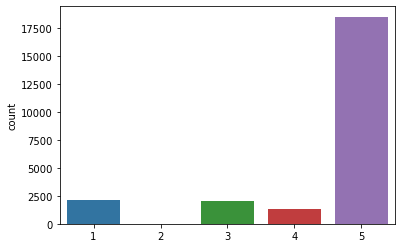

In [24]:
sns.countplot(predict_cdiscount_class)
plt.show();

### Calcul des prédictions sur le jeu de test amazon

In [25]:
df_test.head(2)

,pays,note,titre,commentaire
0,FR,1,nage en eaux troubles,"ll y a 2 joursnage en eaux troublesSystème de vérification de compte horrible, aucunes indications, quand on fournit les pièces demandées ça ne va pas et on nous redemande les mêmes choses par la suite, service client horrible, attente interminable, me voilà bloqué depuis 3 jours et cela n'est toujours pas résolu; aucunes informations sur la suite des démarche, ma pire expérience en matière de résolution des soucis liés à un compteDate de l'expérience: 26 novembre 2022"
1,FR,1,Colis qui fait le tour du monde,ll y a 2 joursColis qui fait le tour du mondeJe ne suis pas adepte cette enseigne mais j'avoue que je n'ai trouvé ce produit nulle part ailleurs mon expérience pour le paiement XXL par contre pour le suivi et la livraison nul archi nul aucun suivi de commande disponible je ne sais d'où vient mon produit c'est mon ultime commande et la deuxième seulement auprès de cette enseigneDate de l'expérience: 26 novembre 2022


In [26]:
# séparation de la variable cible et des variables explicatives
check_set = df_test['commentaire'].values

In [27]:
# vectorisation des token
check_seq = tk.texts_to_sequences(check_set)

In [28]:
# mise sous matrice numpy
check_pad = pad_sequences(check_seq, maxlen=max_words, padding='post')

In [29]:
check_pad

array([[1014,  163,   18, ...,    0,    0,    0],
       [1014,  163,   18, ...,    0,    0,    0],
       [1014,  163,   18, ...,    0,    0,    0],
       ...,
       [  81,   61, 2617, ...,    0,    0,    0],
       [ 127,   34, 1366, ...,    0,    0,    0],
       [  86,   61,   55, ...,    0,    0,    0]])

In [30]:
# création des prédictions du jeu de test amazon à partir du modèle
check_predict = model_embedding_1.predict(check_pad, verbose=1)

4/4 [==============================] - 0s 4ms/step


In [31]:
print(check_predict)

[[0.00000000e+00 9.89978909e-01 8.84264428e-03 1.13994675e-03
  3.82414837e-05 3.22424114e-07]
 [3.59471669e-14 4.98624533e-01 2.26301044e-01 2.12458149e-01
  5.39067350e-02 8.70944932e-03]
 [3.08551339e-36 9.51230824e-01 3.98432650e-02 8.55276082e-03
  3.69343994e-04 3.78825689e-06]
 [1.31790460e-15 4.39319342e-01 2.61756927e-01 2.41129667e-01
  5.25479838e-02 5.24607813e-03]
 [1.14974555e-37 9.89910543e-01 8.47279932e-03 1.49725110e-03
  1.15015304e-04 4.43547606e-06]
 [0.00000000e+00 9.99877810e-01 1.21268917e-04 1.00342447e-06
  1.71709058e-09 1.71718867e-13]
 [0.00000000e+00 9.96326983e-01 3.51401418e-03 1.58580675e-04
  4.82905364e-07 3.39329502e-11]
 [0.00000000e+00 9.99532342e-01 4.55073052e-04 1.24755488e-05
  7.84578091e-08 3.81154761e-11]
 [0.00000000e+00 9.85365868e-01 1.40919024e-02 5.41343179e-04
  7.64680749e-07 1.38116740e-11]
 [0.00000000e+00 9.97595847e-01 2.26945034e-03 1.33068155e-04
  1.71041870e-06 2.96953906e-09]
 [0.00000000e+00 9.39016700e-01 4.85602133e-02 1.2

In [32]:
check_predict_class = check_predict.argmax(axis=1)
check_predict_class

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1,
       1, 5, 4, 4, 3, 1, 3, 1, 1, 1, 5, 5, 4, 1, 3, 1, 1, 5, 3, 5, 4, 1,
       1, 4, 3, 5, 5, 3, 1, 5, 1, 1, 4, 5, 4, 1, 1, 5, 5, 5, 3, 5, 5, 5,
       5, 5, 3, 1, 5, 5, 5, 5, 5, 5, 5, 1], dtype=int64)

C:\Users\t.fourtouill\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


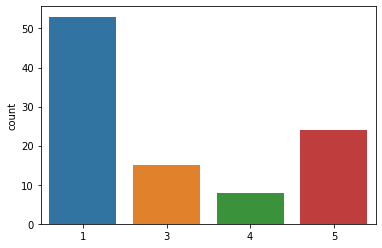

In [33]:
sns.countplot(check_predict_class);

In [34]:
# comparaison des prédictions et des notes du jeu de test
check_df = pd.DataFrame(list(zip(df_test.commentaire, df_test.note, check_predict_class)), columns=['commentaire', 'note', 'prediction'])
check_df.head()

,commentaire,note,prediction
0,"ll y a 2 joursnage en eaux troublesSystème de vérification de compte horrible, aucunes indications, quand on fournit les pièces demandées ça ne va pas et on nous redemande les mêmes choses par la suite, service client horrible, attente interminable, me voilà bloqué depuis 3 jours et cela n'est toujours pas résolu; aucunes informations sur la suite des démarche, ma pire expérience en matière de résolution des soucis liés à un compteDate de l'expérience: 26 novembre 2022",1,1
1,ll y a 2 joursColis qui fait le tour du mondeJe ne suis pas adepte cette enseigne mais j'avoue que je n'ai trouvé ce produit nulle part ailleurs mon expérience pour le paiement XXL par contre pour le suivi et la livraison nul archi nul aucun suivi de commande disponible je ne sais d'où vient mon produit c'est mon ultime commande et la deuxième seulement auprès de cette enseigneDate de l'expérience: 26 novembre 2022,1,1
2,"ll y a 2 joursPromotion mensongèreHier j’ai voulu commandé un jouet avec la promotion affichée « 3 jouets pour 2 ». Il était bien indiqué que la promotion fonctionnait sur le jouet en question. Arrivé au paiement, pas de déduction pour le 3è jouet, je ne commande donc pas et envoie un mail à Amazon avec print écran à l’appui de la promo sur le jouet. L’interlocutrice n’a rien voulu savoir, la promo a été retirée depuis sur le jouet, honteux !! Non seulement les prix varient sans arrêt et en plus ils ne respectent pas les promotions qu’ils mettent en place. J’ai trouvé mon bonheur chez cdiscount, vendeur bien plus sérieuxDate de l'expérience: 24 novembre 2022",1,1
3,"ll y a 3 joursJ’ai commandé un article cadeau sur…J’ai commandé un article cadeau sur Amazon, le fournisseur n’apparaît plus sur le site d’Amazon, je n’ai aucun retour de la part d’Amazon. Ce n’est que 28€ mais de trop si pas de remboursement. Il me paraît impossible d’entrer en contact avec le service « commercial » après plusieurs tentatives, avez-vous un numéro ou une adresse ? Merci de votre aideDate de l'expérience: 23 novembre 2022",1,1
4,"ll y a 3 joursJ'ai commandé un téléphone portable sur…J'ai commandé un téléphone portable sur le site, reçu mais après lecture de la documentation technique, ce téléphone n'avait pas les fonctions indiquées sur l'annonce, bon l'erreur est humaine, je renvois le matériel avec l'autorisation d'Amazon le 8 novembre, malgré les divers contacts et relances, aucun remboursement ce jour soit le 25 novembre, depuis j'ai acheté un autre téléphone, je me suis fais escroqué de 140 euros, voilà c'est Amazon, ca à bien changé, faites attention.Date de l'expérience: 08 novembre 2022",1,1


In [35]:
from sklearn.metrics import classification_report

cr = classification_report(y_test, predict_cdiscount_class)
print(cr)

cm = pd.crosstab(y_test, predict_cdiscount_class, rownames=['données réelles'], colnames=['predictions'])
display(cm)

# vérification des résultats sur un jeu de test externe (100 commentaires amazon également répartis entre les étoiles)

cm_test = classification_report(df_test.note, check_predict_class)
print(cm_test)

cm_test2 = pd.crosstab(df_test.note, check_predict_class, rownames=['données réelles'], colnames=['predictions'])
display(cm_test2)

cm_test3 = pd.crosstab(df_test.note, check_predict_class, rownames=['données réelles'], colnames=['predictions'], normalize=0)
display(cm_test3)

for i in cm_test3.index:
    for j in cm_test3.columns :
        if (i==j and cm_test3.loc[i, j] > 0.5) :
            print("les prédictions correctes sont supérieures à 50% pour {} étoile(s) avec {:0.0%}".format(i, cm_test3.loc[i, j]))

              precision    recall  f1-score   support

           1       0.73      0.76      0.75      1999
           2       0.32      0.01      0.03       535
           3       0.32      0.47      0.38      1375
           4       0.57      0.15      0.23      5143
           5       0.77      0.95      0.85     14948

    accuracy                           0.72     24000
   macro avg       0.54      0.47      0.45     24000
weighted avg       0.69      0.72      0.67     24000



predictions,1,2,3,4,5
données réelles,,,,,
1,1527,15,308,17,132
2,197,7,244,17,70
3,180,0,650,180,365
4,105,0,572,753,3713
5,85,0,232,364,14267


              precision    recall  f1-score   support

           1       0.34      0.90      0.49        20
           2       0.00      0.00      0.00        20
           3       0.40      0.30      0.34        20
           4       0.50      0.20      0.29        20
           5       0.62      0.75      0.68        20

    accuracy                           0.43       100
   macro avg       0.37      0.43      0.36       100
weighted avg       0.37      0.43      0.36       100



C:\Users\t.fourtouill\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t.fourtouill\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t.fourtouill\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


predictions,1,3,4,5
données réelles,,,,
1,18,1,1,0
2,17,3,0,0
3,8,6,3,3
4,7,3,4,6
5,3,2,0,15


predictions,1,3,4,5
données réelles,,,,
1,0.90,0.05,0.05,0.00
2,0.85,0.15,0.00,0.00
3,0.40,0.30,0.15,0.15
4,0.35,0.15,0.20,0.30
5,0.15,0.10,0.00,0.75


les prédictions correctes sont supérieures à 50% pour 1 étoile(s) avec 90%
les prédictions correctes sont supérieures à 50% pour 5 étoile(s) avec 75%


In [37]:
import os
path = "/Users/t.fourtouill/Downloads/SatisfactionClients"
os.makedirs(path, exist_ok=True)
model_embedding_1.save('datasets/SatisfactionClients/model_embedding8')

INFO:tensorflow:Assets written to: datasets/SatisfactionClients/model_embedding9\assets
